# Data Preparation for Unet Training

In this file a dataset is created to train a 3D Unet with. This task encompasses the following steps:

- Open Tiff Stacks / h5 or n5 files
- data exploration and visualization
- sample mining
- creation of training datasets

In [2]:
import numpy as np 
import os, sys
import matplotlib.pyplot as plt
from importlib import reload

import h5py, z5py

sys.path.append('../tools/')
import tilingStrategy, Dataset3D, visualization

## Open the file and load the potentially large image volume

In [2]:
# Open an image volume
image_path = "C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\large_image_0724.h5"
image_h5 = h5py.File(image_path, mode='r+') # Open h5 file with read / write access
print(image_h5['t0'].keys()) # Show Groups (Folders) in root Group of the h5 archive

image = image_h5['t0/channel0']

mask_path = "C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\large_mask_0724.h5"
mask_h5 = h5py.File(mask_path, mode='r') # Open h5 file with read / write access

mask = mask_h5['t0/channel0']
print('loaded image with shape {}\nloaded mask with shape {}'.format(image.shape, mask.shape))

<KeysViewHDF5 ['channel0', 'unet']>
loaded image with shape (500, 2000, 2000)
loaded mask with shape (500, 2000, 2000)


## Explore the data

The neuron is a branched and thin structure. While it's proportion is small in 3D images it occupies an even smaller proportion of the imaged volume.
While empty samples have to be included to train the network, samples containing the neuron should be preferred as they are much more informative.

### Thresholding by mean signal strength
As a proxy one could try to choose samples based on their mean signal strength.

In [3]:
# Use UnetTiler to tile the image volume with a rectangular grid
tiler = tilingStrategy.UnetTiler3D(image=image, mask=mask, output_shape=(132,132,132), input_shape=(220,220,220))
# since input = ouput shape there is no padding

In [4]:
indices = Dataset3D.getRandomIndices(tiler, n_samples=300) # sample random tiles from the image volume
signal_strengths = Dataset3D.getMeanSignalStrengths(tiler, indices) # With about 17% of samples containing the neuron this should be enough sampling to collect 50 samples for the dataset

100%|██████████| 300/300 [00:14<00:00, 21.42it/s]


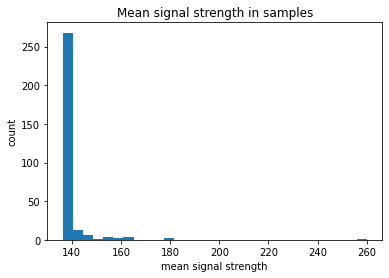

In [5]:
# Plot the distribution of the mean signal strength in our samples
_ = plt.hist(signal_strengths, bins=30)
plt.title('Mean signal strength in samples')
plt.xlabel('mean signal strength')
plt.ylabel('count')
plt.show()

In [6]:
np.count_nonzero([s > 139 for s in signal_strengths]) / len(indices)

0.12666666666666668

In [7]:
# Prepare a dataset with thresholded Sampling:
thresholded = Dataset3D.thresholdedSampling(indices,signal_strengths,threshold=149,n_samples=50,object_ratio=0.9)

### Thresholding by proportion of masked volume (not background) in the sample mask
Alternatively, since a dataset is generated from labeled data, we can use the mean proportion of the masked volume to identify interesting samples

100%|██████████| 300/300 [00:14<00:00, 20.71it/s]


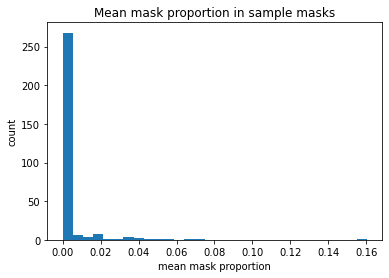

In [8]:
mask_proportions = Dataset3D.sampleMaskProportion(tiler, indices)
# Plot the distribution of the mean signal strength in our samples
_ = plt.hist(mask_proportions, bins=30)
plt.title('Mean mask proportion in sample masks')
plt.xlabel('mean mask proportion')
plt.ylabel('count')
plt.show()

In [9]:
np.count_nonzero([s > 0.001 for s in mask_proportions])

44

Text(0.5, 1.0, 'Relation of mask proportion and signal strength in randomly sampled tiled')

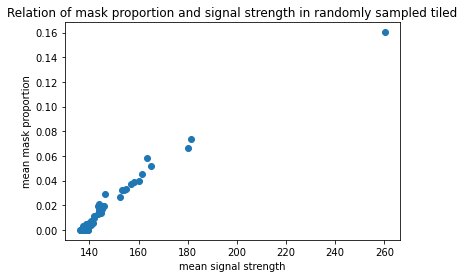

In [10]:
# visualiz ethe relation between mean signal strength and mask proportion
plt.figure()
plt.scatter(signal_strengths, mask_proportions)
plt.xlabel('mean signal strength')
plt.ylabel('mean mask proportion')
plt.title('Relation of mask proportion and signal strength in randomly sampled tiled')

In [11]:
# Prepare a detaset with mask thresholded sampling
mask_thresholded = Dataset3D.thresholdedSampling(indices, mask_proportions, threshold=0.001, object_ratio=0.9, n_samples=50)

In [ ]:
# Prepare a completely random sample from the dataset (baseline comparison):
random = np.random.choice(indices, size=5)
for i in random:
    visualization.showZSlices(tiler.getSlice(i), mode='h5')

In [ ]:
# Visualize the mean mean signal thresholded sampling
for i in thresholded[:5]:
    visualization.showZSlices(tiler.getSlice(i), mode='h5')

In [ ]:
# Visualize the mask thresholded sampling
for i in mask_thresholded[:5]:
    visualization.showZSlices(tiler.getSlice(i), mode='h5')

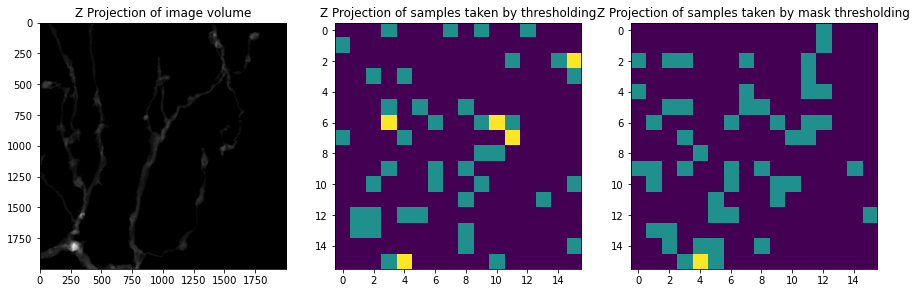

In [15]:
# Visualize which regions were sampled from the tiling, verify overlap with dataset content
thresholded_dist = np.zeros((4,16,16))
for sample in thresholded:
    coords = tiler._indexToCoordinates(sample)
    thresholded_dist[coords] = 1

mask_thresholded_dist = np.zeros((4,16,16))
for sample in mask_thresholded:
    coords = tiler._indexToCoordinates(sample)
    mask_thresholded_dist[coords] = 1 

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.gca().set_title('Z Projection of image volume')
plt.imshow(np.sum(np.clip(mask,0,1), axis=0), cmap='gray')
plt.subplot(1,3,2)
plt.gca().set_title('Z Projection of samples taken by thresholding')
plt.imshow(np.sum(thresholded_dist, axis=0))
plt.subplot(1,3,3)
plt.gca().set_title('Z Projection of samples taken by mask thresholding')
plt.imshow(np.sum(mask_thresholded_dist, axis=0))

## Create a dataset

Use the Dataset3D class to create a new dataset or append to an existing one.
Datasets contain named entries that hold an input image and it's corresponding mask together with some metadata.

In [3]:
reload(Dataset3D)
dataset = Dataset3D.Dataset(dataset_path='C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\test_dataset.h5')
dataset.keys()

Opened dataset with 47 preexisting items. Overwriting items with the same name.


<KeysViewHDF5 ['210', '216', '23', '256', '259', '283', '306', '323', '326', '330', '345', '359', '390', '394', '395', '406', '411', '423', '426', '438', '441', '481', '486', '488', '491', '522', '525', '541', '571', '576', '583', '604', '609', '615', '653', '662', '672', '677', '733', '736', '757', '794', '826', '865', '900', '913', '962']>

In [13]:
dataset.add_tiles(tiler, mask_thresholded, metadata={'source_image':image_path, 'preprocessing':'None', 'date':'20200802'})

Tiles added: 100%|██████████| 50/50 [00:09<00:00,  5.44it/s]


In [4]:
# collect the mask proportion of all samples that were picked for the dataset
mask_thresholded_object_ratio = [mask_proportion[i] for i in range(len(mask_proportions)) if indices[i] in mask_thresholded]

# Calculate the ratio of neuron to background pixels in the training set so that we can adjust class weights during training

object_ratio = np.mean(mask_thresholded_object_ratio) # mean = sum / tot_pixels = the proportion of class label 1
object_weight = 1 / object_ratio # devide by proportion of cases to factor out imbalance of case numbers
background_weight = 1 / (1-object_ratio)
print('class weights background (0) * {:.3f} objects (1) * {:.3f}'.format(background_weight, object_weight))

# Save the calculated class weights as dataset attributes
dataset.setAttribute('background_weight',background_weight)
dataset.setAttribute('object_weight',object_weight)

NameError: name 'mask_proportions' is not defined

In [14]:
# Close the dataset
print(dataset.keys())
dataset.close()

<KeysViewHDF5 ['210', '216', '23', '243', '256', '259', '283', '306', '323', '326', '330', '345', '359', '390', '394', '395', '399', '406', '411', '423', '426', '438', '441', '481', '486', '488', '491', '522', '525', '541', '543', '571', '576', '583', '604', '609', '615', '653', '662', '672', '677', '733', '736', '757', '794', '826', '865', '900', '913', '962']>


## Inspect a prepared dataset

In [16]:
# Open the dataset
reload(Dataset3D)
dataset = Dataset3D.Dataset('C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\test_dataset.h5')

Opened dataset with 50 preexisting items. Overwriting items with the same name.


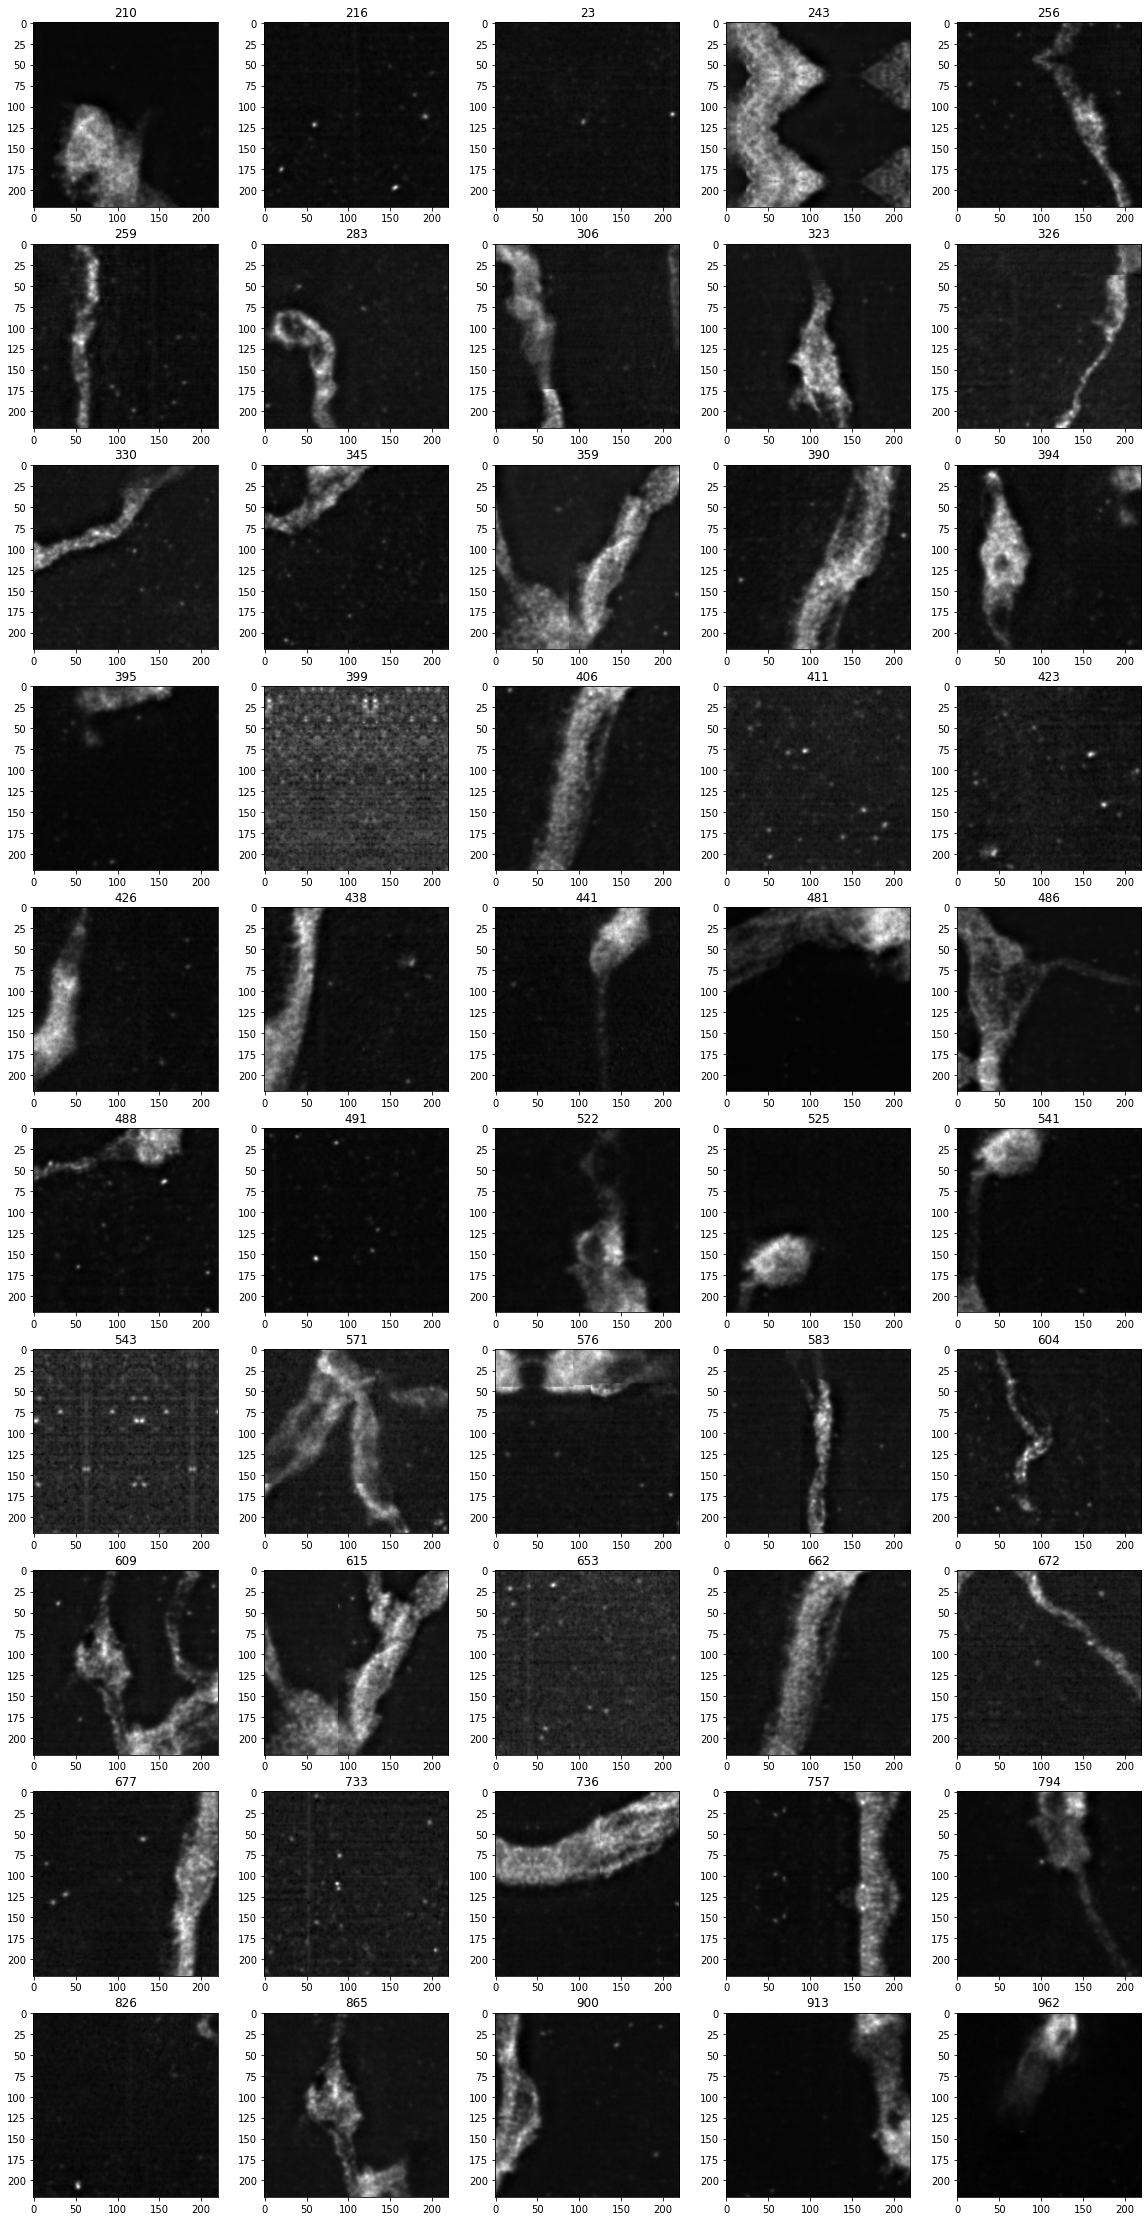

In [17]:
# Visualize the content of a generated dataset
plt.figure(figsize=(20,40))
samples = list(dataset.keys())
for i, sample in enumerate(samples):
    plt.subplot(10,5,i+1)
    plt.gca().set_title(sample)
    plt.imshow(np.sum(dataset.get(sample)[0], axis=0), cmap='gray',)

In [18]:
bad_entries = [243,399,543]
[dataset.delete(entry) for entry in bad_entries]

[None, None, None]

In [19]:
dataset.close()